# Project Description
1. I will build a deep learning model capable of accurately segmenting a Yoda overlayed on generated background images. This will demonstrate that such a task can be achieved with only a small training set.
2. Based on the segmentation mask predicted by the model, I will implement an algorithm that finds a convex hull, i.e. a polygon enclosing all the foreground pixels.
3. I will implement an algorithm that calculates the area of the polygon from the result of the convex hull determination.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

In [23]:
yoda_image = Image.open('./yoda.png')
print(yoda_image.mode, yoda_image.size)
yoda_image = yoda_image.crop((160, 0, 680, 481))
yoda_image_256x256 = yoda_image.resize((256, 256))

RGBA (820, 668)


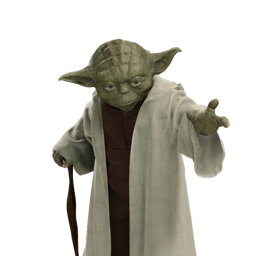

In [65]:
yoda_image_256x256

# Background Images

Use a generative adversarial network called "BigGAN" pre-trained on ImageNet to create a set of background images 

In [ ]:
# first, we need to install the python package called `pytorch_pretrained_biggan` (https://github.com/huggingface/pytorch-pretrained-BigGAN)
!pip install pytorch_pretrained_biggan

In [16]:
import torch
from pytorch_pretrained_biggan import (
    BigGAN,
    truncated_noise_sample,
    convert_to_images,
    one_hot_from_int,
)

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# boilerplate pytorch code enforcing reproducibility
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

BigGAN is a memory-intensive network.

In [43]:
# load the 256x256 model
model = BigGAN.from_pretrained('biggan-deep-256').to(device).eval()

# every time we will run with batch size of 3 in order to not run out of memory
num_passes_train = 20
num_passes_test = 2
batch_size = 3

# default noise value from the provided repository
truncation = 0.4

background_images = []
test_background_images = []

# create training background images 
for _ in range(num_passes_train):
    # BigGAN uses imagenet and hence each time we will choose one of 1000 categories
    class_vector = torch.from_numpy(
        one_hot_from_int(np.random.randint(0, 1000, size=batch_size), batch_size=batch_size)
    ).to(device)
    noise_vector = torch.from_numpy(
        truncated_noise_sample(truncation=truncation, batch_size=batch_size)
    ).to(device)

    # Generate the images and convert them to PIL image
    with torch.no_grad():
        output = model(noise_vector, class_vector, truncation).cpu()
        background_images.extend(convert_to_images(output))

# create test background images 
for _ in range(num_passes_test):
    # BigGAN uses imagenet and hence each time we will choose one of 1000 categories
    class_vector = torch.from_numpy(
        one_hot_from_int(np.random.randint(0, 1000, size=batch_size), batch_size=batch_size)
    ).to(device)
    noise_vector = torch.from_numpy(
        truncated_noise_sample(truncation=truncation, batch_size=batch_size)
    ).to(device)

    # Generate the images and convert them to PIL image
    with torch.no_grad():
        output = model(noise_vector, class_vector, truncation).cpu()
        test_background_images.extend(convert_to_images(output))

# We won't need the GAN model anymore,
# so we can safely delete it and free up some memory
del model
torch.cuda.empty_cache()

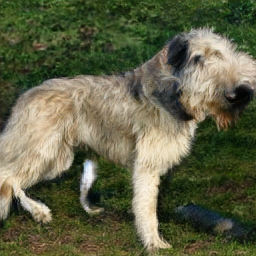

In [58]:
# Let's see how one of the images look like
random.choice(background_images)

# Create Training/Val and Test datasets 
Given the training background images and the yoda image, we will paste the yoda onto the background images.

In [68]:
import torchvision
import torchvision.transforms as transforms

In [79]:
tensor_transform = transforms.ToTensor()

def random_paste(background_image, yoda_image, min_scale=0.5, max_scale=0.75):
    """Randomly scales and pastes the yoda image onto the background image"""
    
    w, h = yoda_image.size
    # first, we will randomly downscale the yoda image
    new_w = int(random.uniform(min_scale, max_scale) * w)
    new_h = int(random.uniform(min_scale, max_scale) * h * 0.9)
    resized_yoda_image = yoda_image.resize((new_w, new_h))

    # second, will randomly choose the locations where to paste the new image
    start_w = random.randint(0, w - new_w)
    start_h = random.randint(0, h - new_h)

    # third, will create the blank canvas of the same size as the original image
    canvas_image = Image.new('RGBA', (w, h))

    # and paste the resized yoda onto it, preserving the mask
    canvas_image.paste(resized_yoda_image, (start_w, start_h), resized_yoda_image)
    
    # yoda image is of mode RGBA, while background image is of mode RGB;
    # `.paste` requires both of them to be of the same type.
    background_image = background_image.copy().convert('RGBA')

    # Rotate the background image by a random angle 
    angle = random.randint(-45, 45)
    background_image = background_image.rotate(angle)

    # finally, will paste the resized yoda onto the background image
    background_image.paste(resized_yoda_image, (start_w, start_h), resized_yoda_image)
    return background_image, canvas_image

In [80]:
def create_dataset(background_images):
    dataset = []  # image, segmentation mask

    for background_image in background_images:
        # paste the yoda onto background image
        aug_image, aug_mask = random_paste(background_image.copy(), yoda_image_256x256.copy())
        # convert PIL images to pytorch tensors
        training_pair = [
            tensor_transform(aug_image)[:3],  # keep the rgb only
            # For the mask, we only need the last (4th) channel,
            # and we will encode the mask as boolean
            tensor_transform(aug_mask)[-1:] > 0,
        ]
        dataset.append(training_pair)

    return dataset

In [81]:
training_set = create_dataset(background_images=background_images)
test_set = create_dataset(background_images=test_background_images)

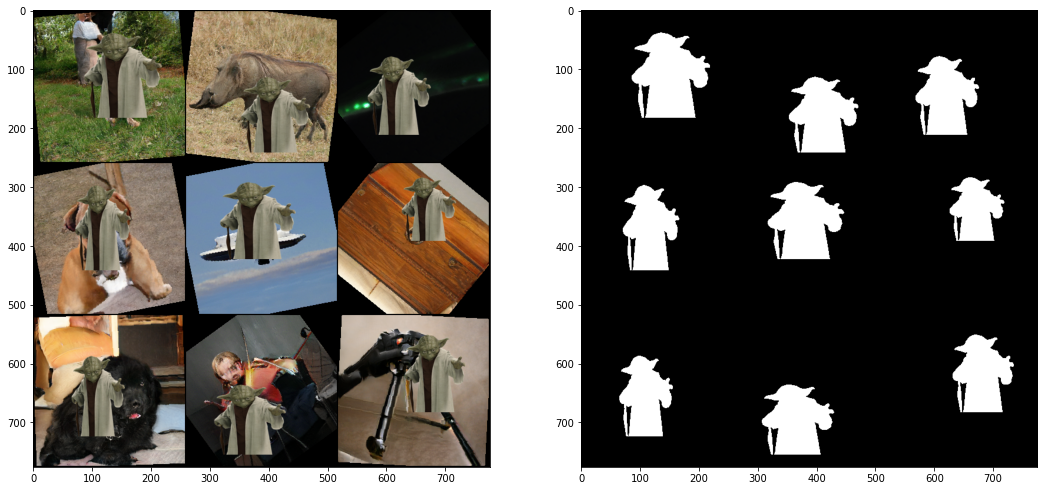

In [82]:
# Visualize a random subset of the training set
sample_indices = np.random.choice(len(training_set), size=9, replace=False)
sample_images = []
sample_masks = []
for i in sample_indices:
    image, mask = training_set[i]
    sample_images.append(image)
    sample_masks.append(mask)
    
plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(sample_images, nrow=3).permute(1, 2, 0).cpu().numpy())
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(sample_masks, nrow=3).permute(1, 2, 0).float().cpu().numpy())

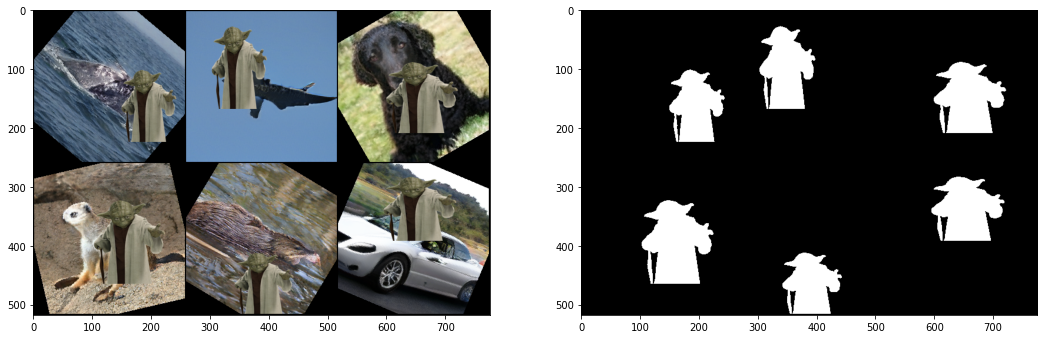

In [83]:
# Visualize the test set 
sample_indices = np.random.choice(len(test_set), size=len(test_set), replace=False)
sample_images = []
sample_masks = []
for i in sample_indices:
    image, mask = test_set[i]
    sample_images.append(image)
    sample_masks.append(mask)
    
plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(sample_images, nrow=3).permute(1, 2, 0).cpu().numpy())
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(sample_masks, nrow=3).permute(1, 2, 0).float().cpu().numpy())

In [89]:
print("The total number of generated training/val images is: %i" %len(training_set))
print("The total number of generated test images is: %i" %len(test_set))

The total number of generated training/val images is: 60
The total number of generated test images is: 6


In [91]:
# Separate the dataset into training and validation sets 
from sklearn.model_selection import train_test_split

def create_img_mask_lists(dataset, image_data, mask_data):
    '''Create two separate lists, one with image data and one with mask data '''
    for i in range(len(dataset)):
        image, mask = dataset[i]
        image_data.append(image)
        mask_data.append(mask)
    print(len(image_data), len(mask_data))

def create_train_val_split(image_data, mask_data):
    '''Create the TensorDataset objects for training and validation sets after splitting'''
    train_imgs, val_imgs, train_masks, val_masks = train_test_split(image_data, mask_data, test_size=0.1, random_state=100)
    # Stack the lists of tensors into single tensors 
    train_imgs = torch.stack(train_imgs)
    val_imgs = torch.stack(val_imgs)
    train_masks = torch.stack(train_masks).to(torch.float32)
    val_masks = torch.stack(val_masks).to(torch.float32)
    # Create dataset objects for the training and validation sets 
    train_dataset = torch.utils.data.TensorDataset(train_imgs, train_masks)
    val_dataset = torch.utils.data.TensorDataset(val_imgs, val_masks)
    return train_dataset, val_dataset

In [92]:
# Create final dataset objects 
train_image_data = []
train_mask_data = []
create_img_mask_lists(training_set, train_image_data, train_mask_data)
train_dataset, val_dataset = create_train_val_split(train_image_data, train_mask_data)

60 60


In [97]:
# The test_image_data will contain the test image tensors 
test_image_data = []
test_mask_data = []
create_img_mask_lists(test_set, test_image_data, test_mask_data)

6 6


# Model Creation and Training

In [117]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models 
from sklearn.metrics import f1_score
import time
import copy

def calculate_pixels_ratio(mask): 
    '''Calculate the ratio between the number of negative pixels to positive pixels''' 
    print(mask.shape)
    pos_pixels = len(np.column_stack(np.where(mask > 0)))
    neg_pixels = len(np.column_stack(np.where(mask == 0)))
    image_area = mask.shape[0] * mask.shape[1]
    print("Positive pixels make up {} percent of total pixels".format(pos_pixels / image_area * 100))
    print("Negative pixels make up {} percent of total pixels".format(neg_pixels / image_area * 100))
    return neg_pixels / pos_pixels

def get_loader(input_dataset, batch_size):
    loaded = torch.utils.data.DataLoader(input_dataset, batch_size = batch_size, num_workers = 1, shuffle = False)
    return loaded

def create_deepLabV3(output_channels):
    # Obtain pretrained deeplabV3 model 
    model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)
    # Make a new classifier head to be traine on our dataset  
    model.classifier = DeepLabHead(2048, output_channels)
    return model

def evaluate_metric(model, data_loader):
    model.eval()
    total = 0 
    n = 0 
    for imgs, masks in data_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        out = model(imgs)['out']
        y_pred = out.data.cpu().numpy().ravel()
        y_true = masks.data.cpu().numpy().ravel()
        total += f1_score(y_true > 0, y_pred > 0.01)
        n += imgs.shape[0]
    return total / n

def train(model, train_dataset, val_dataset, criterion, optimizer, num_epochs=1, batch_size=1):
    # Create DataLoader objects 
    train_loader = get_loader(train_dataset, batch_size)
    val_loader =  get_loader(val_dataset, batch_size)

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    model = model.to(device)

    iters, losses, train_acc, val_acc = [], [], [], []
    print ("Training Started...")
    n = 0 
    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)        
        # Each epoch has a training and validation phase
        model.train()
        # Iterate over data.
        for imgs, masks in iter(train_loader):
            imgs = imgs.to(device)
            masks = masks.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            out = model(imgs)['out'].to(device)
            loss = criterion(out, masks)
            loss.backward()
            optimizer.step()
            n += 1 

        # After each epoch, update the best_model_wts if the loss decreased 
        print('Epoch {} Loss: {:.4f}'.format(epoch,loss))
        if loss < best_loss:
            best_loss = loss
            best_model_wts = copy.deepcopy(model.state_dict())

        iters.append(n)
        losses.append(float(loss)/batch_size)
        train_acc.append(evaluate_metric(model, train_loader))
        val_acc.append(evaluate_metric(model, val_loader))
    
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

In [114]:
# Use one image mask as an example in order to determine the approximate pixels ratio 
sample_mask = train_mask_data[0].squeeze(0)
pixels_ratio = calculate_pixels_ratio(sample_mask.numpy())
print("The pixels ratio is: {}".format(pixels_ratio))

(256, 256)
Positive pixels make up 12.7685546875 percent of total pixels
Negative pixels make up 87.2314453125 percent of total pixels
The pixels ratio is: 6.831739961759082


In [127]:
# Create model and training parameters 
deepLabV3_model = create_deepLabV3(1)
# The loss will the Binary Cross Entropy with a weight towards positive pixels which are numbered roughly 1 to 7 to negative pixels. 
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pixels_ratio]).to(device))
# Use Adam optimizer 
optimizer = torch.optim.Adam(deepLabV3_model.parameters(), lr=1e-3)

Training Started...
Epoch 1/20
----------
Epoch 1 Loss: 0.2072
Epoch 2/20
----------
Epoch 2 Loss: 0.1308
Epoch 3/20
----------
Epoch 3 Loss: 0.1026
Epoch 4/20
----------
Epoch 4 Loss: 0.0878
Epoch 5/20
----------
Epoch 5 Loss: 0.0816
Epoch 6/20
----------
Epoch 6 Loss: 0.0697
Epoch 7/20
----------
Epoch 7 Loss: 0.0664
Epoch 8/20
----------
Epoch 8 Loss: 0.0543
Epoch 9/20
----------
Epoch 9 Loss: 0.0532
Epoch 10/20
----------
Epoch 10 Loss: 0.0589
Epoch 11/20
----------
Epoch 11 Loss: 0.0489
Epoch 12/20
----------
Epoch 12 Loss: 0.0485
Epoch 13/20
----------
Epoch 13 Loss: 0.0463
Epoch 14/20
----------
Epoch 14 Loss: 0.0465
Epoch 15/20
----------
Epoch 15 Loss: 0.0508
Epoch 16/20
----------
Epoch 16 Loss: 0.0466
Epoch 17/20
----------
Epoch 17 Loss: 0.0423
Epoch 18/20
----------
Epoch 18 Loss: 0.0382
Epoch 19/20
----------
Epoch 19 Loss: 0.0336
Epoch 20/20
----------
Epoch 20 Loss: 0.0353


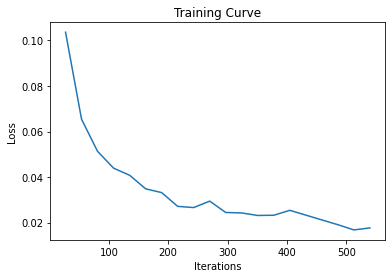

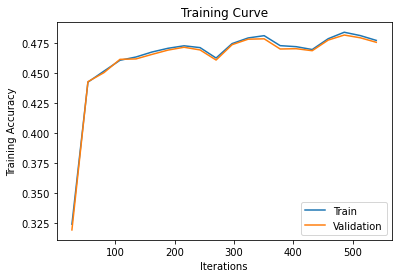

Training complete in 5m 34s
Lowest Loss: 0.033571


In [128]:
# Train model on new data 
with torch.no_grad():
    torch.cuda.empty_cache()
train(deepLabV3_model, train_dataset, val_dataset, criterion, optimizer, num_epochs=20, batch_size=2)

In [148]:
# save the model weights 
torch.save(deepLabV3_model.state_dict(), "deepLabV3_20_1e3.pt")

# Prediction on Test Images

torch.Size([1, 3, 256, 256])


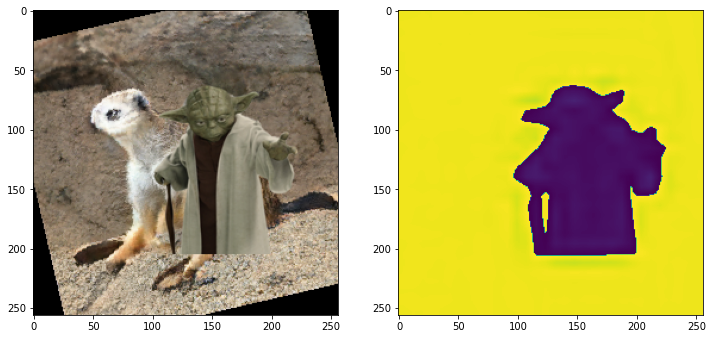

In [135]:
test_image = test_image_data[5]
test_image_tensor = test_image.unsqueeze(0).to(device)
print(test_image_tensor.shape)
test_mask_tensor = deepLabV3_model(test_image_tensor)['out'].byte()

plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(test_image_tensor.cpu().numpy().squeeze(0).transpose(1, 2, 0))
plt.subplot(122)
plt.imshow(test_mask_tensor.cpu().numpy().squeeze(0).transpose(1, 2, 0))

We will plot each test image, its true mask, and its predicted mask in a 6 by 3 plot.

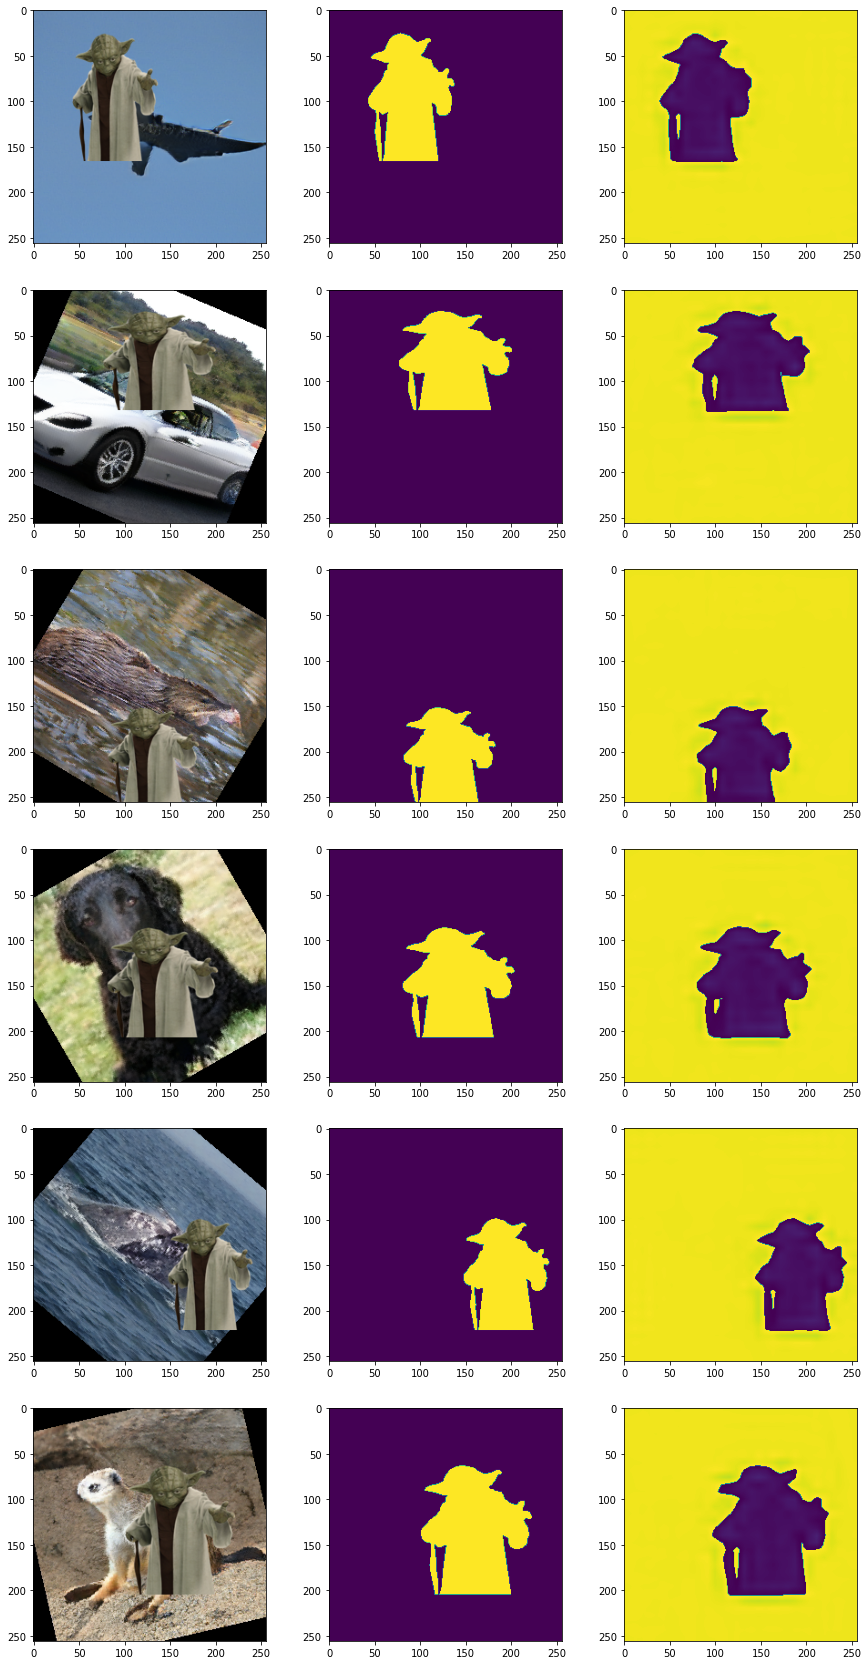

In [184]:
# Perform prediction on each test image 
deepLabV3_model.eval()
predicted_masks = []
fig = plt.figure(figsize=(15, 30))
columns, rows = 3, 6
for i in range(len(test_image_data)):
    test_img, test_mask = test_image_data[i], test_mask_data[i]

    test_image_tensor = test_img.unsqueeze(0).to(device)
    predicted_mask = deepLabV3_model(test_image_tensor)['out'].byte().cpu().squeeze(0)
    predicted_masks.append(predicted_mask)
    
    plt.subplot(rows, columns, i*3+1)
    plt.imshow(test_img.numpy().transpose(1, 2, 0))
    plt.subplot(rows, columns, i*3+2)
    plt.imshow(test_mask.numpy().transpose(1, 2, 0))
    plt.subplot(rows, columns, i*3+3)
    plt.imshow(predicted_mask.numpy().transpose(1, 2, 0))

Post processing is needed on the predicted masks. 
1. Invert the masks such that the positive pixels correspond to the Yoda area.
2. Normalize the pixel values to be between 0 and 1. 
3. Threshold the images using a threshold of 0.8, such that all pixels are either 0 or 1.

In [197]:
# Apply post-processing on predicted masks
threshold = 0.9
processed_masks = []
for predicted_mask in predicted_masks:
    predicted_mask = predicted_mask.numpy().squeeze(0)
    predicted_mask = np.invert(predicted_mask)
    predicted_mask = np.divide(predicted_mask, predicted_mask.max()) 
    predicted_mask[predicted_mask > threshold] = 1
    predicted_mask[predicted_mask <= threshold] = 0
    ratio = calculate_pixels_ratio(predicted_mask)
    processed_masks.append(predicted_mask)

(256, 256)
Positive pixels make up 15.03143310546875 percent of total pixels
Negative pixels make up 84.96856689453125 percent of total pixels
(256, 256)
Positive pixels make up 15.14129638671875 percent of total pixels
Negative pixels make up 84.85870361328125 percent of total pixels
(256, 256)
Positive pixels make up 11.88812255859375 percent of total pixels
Negative pixels make up 88.11187744140625 percent of total pixels
(256, 256)
Positive pixels make up 16.522216796875 percent of total pixels
Negative pixels make up 83.477783203125 percent of total pixels
(256, 256)
Positive pixels make up 13.19122314453125 percent of total pixels
Negative pixels make up 86.80877685546875 percent of total pixels
(256, 256)
Positive pixels make up 19.158935546875 percent of total pixels
Negative pixels make up 80.841064453125 percent of total pixels


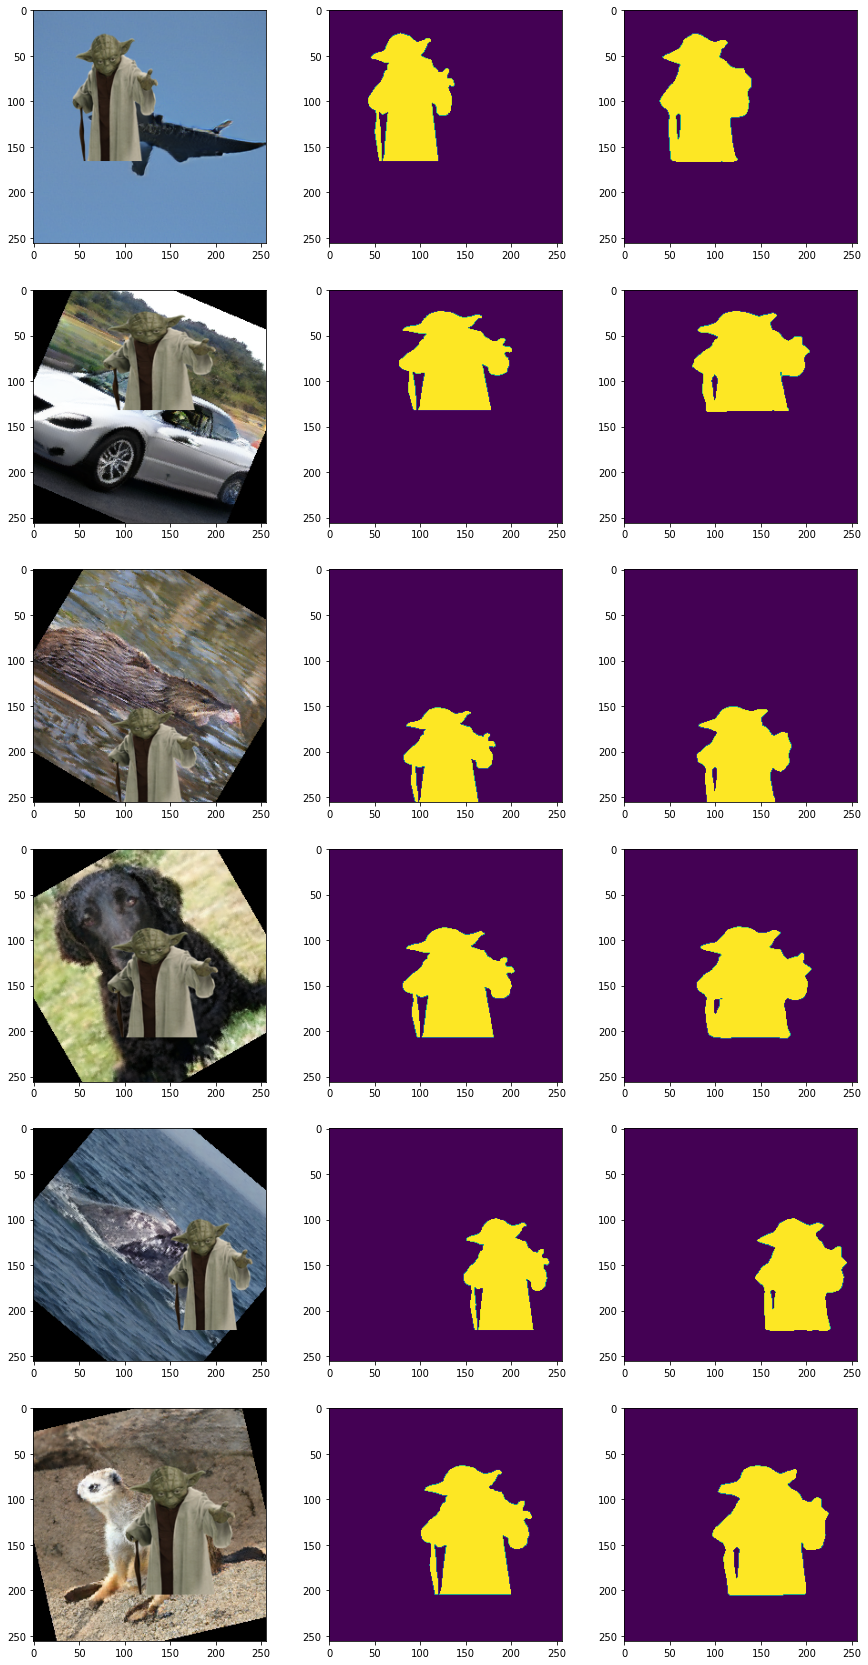

In [198]:
# Display the final, post-processed predicted masks
fig = plt.figure(figsize=(15, 30))
columns, rows = 3, 6
for i in range(len(test_image_data)):
    test_img, test_mask, predicted_mask = test_image_data[i], test_mask_data[i], processed_masks[i]
    
    plt.subplot(rows, columns, i*3+1)
    plt.imshow(test_img.numpy().transpose(1, 2, 0))
    plt.subplot(rows, columns, i*3+2)
    plt.imshow(test_mask.numpy().transpose(1, 2, 0))
    plt.subplot(rows, columns, i*3+3)
    plt.imshow(predicted_mask)

In [235]:
# Compute the precision for each test image result
for i in range(len(test_mask_data)): 
    test_mask = test_mask_data[i].numpy().squeeze(0)
    predicted_mask = processed_masks[i]

    original_neg = test_mask[np.where(test_mask==0)].size
    differ = np.sum(np.logical_and(test_mask==0, predicted_mask==1))
    fp_rate = differ / original_neg * 100

    original_pos = test_mask[np.where(test_mask==1)].size
    differ = np.sum(np.logical_and(test_mask==1, predicted_mask==0))
    fn_rate = differ / original_pos * 100

    print("Test image %d has False Positive Rate: %.3f percent and False Negative Rate: %.3f percent" %(i, fp_rate, fn_rate))

Test image 0 has False Positive Rate: 1.751 percent and False Negative Rate: 0.427 percent
Test image 1 has False Positive Rate: 1.500 percent and False Negative Rate: 0.033 percent
Test image 2 has False Positive Rate: 1.297 percent and False Negative Rate: 0.000 percent
Test image 3 has False Positive Rate: 1.680 percent and False Negative Rate: 0.010 percent
Test image 4 has False Positive Rate: 1.607 percent and False Negative Rate: 0.065 percent
Test image 5 has False Positive Rate: 1.864 percent and False Negative Rate: 0.052 percent
